In [4]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ['Normal', 'Fraud']

In [5]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

In [6]:
df.shape

(19898, 31)

In [7]:
df.isnull().values.any()

True

Text(0, 0.5, 'Frequency')

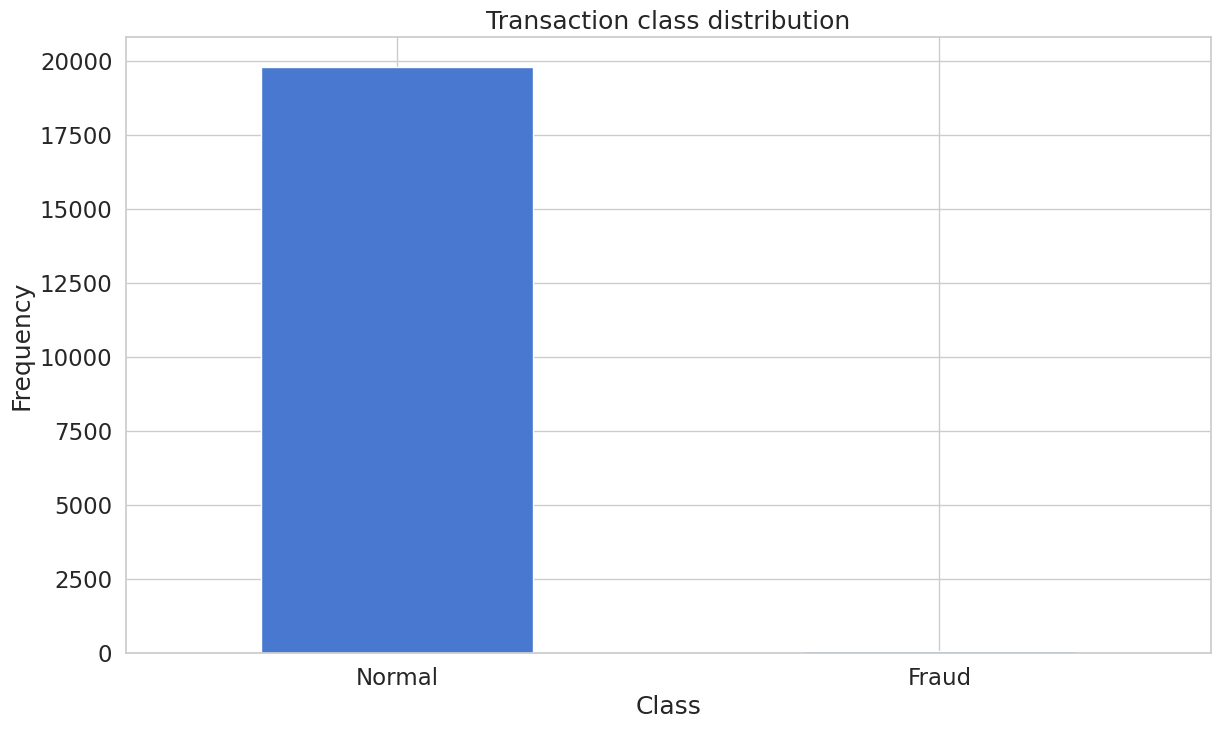

In [8]:
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind = 'bar', rot=0)
plt.title('Transaction class distribution')
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [11]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(85, 31)

In [12]:
normal.shape

(19812, 31)

In [14]:
frauds.Amount.describe()

count      85.000000
mean       93.869647
std       261.736641
min         0.000000
25%         1.000000
50%         1.000000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()

count    19812.000000
mean        70.169855
std        205.091118
min          0.000000
25%          5.900000
50%         16.070000
75%         59.950000
max       7879.420000
Name: Amount, dtype: float64

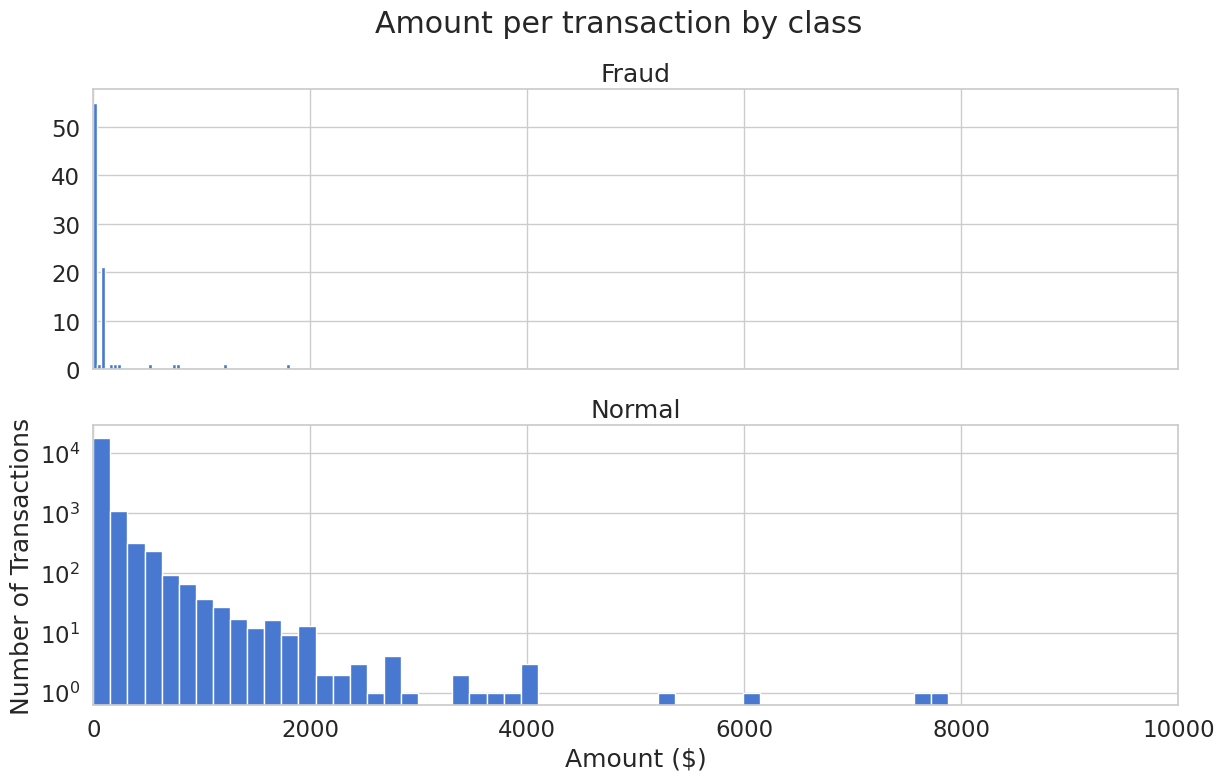

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000))
plt.yscale('log')
plt.show()

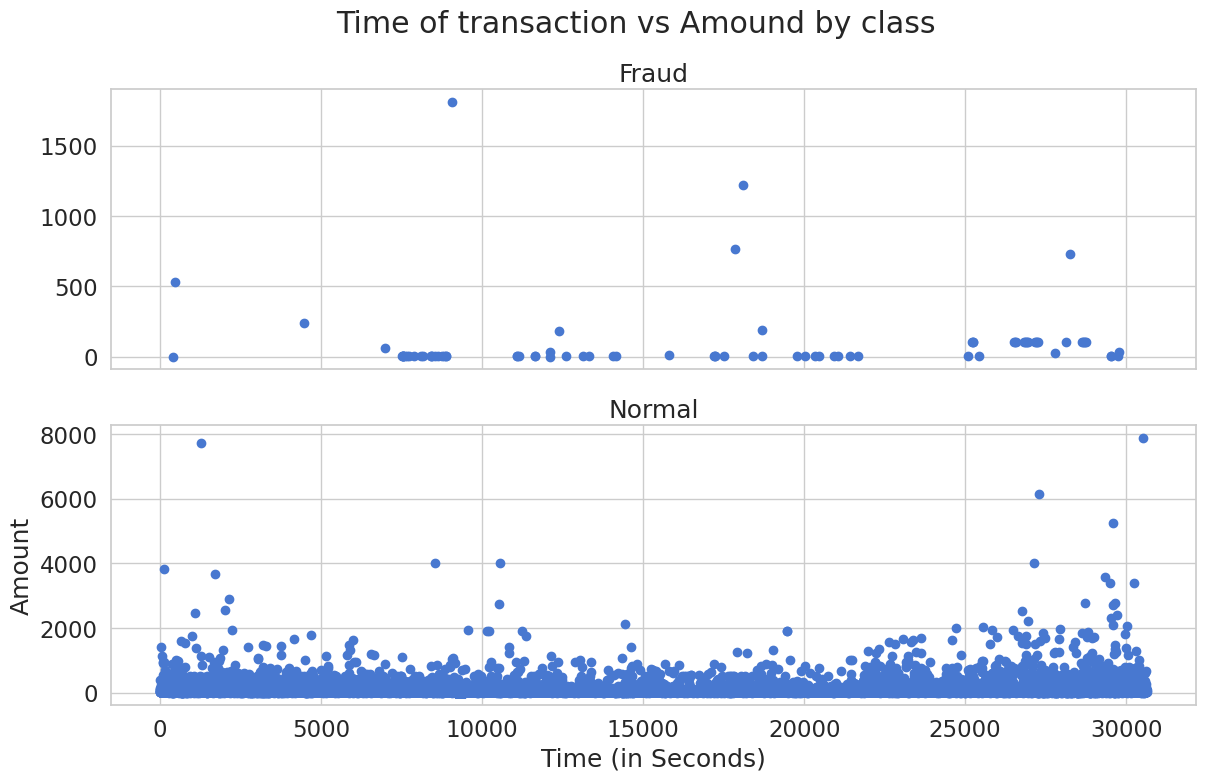

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amound by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [25]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(15846, 29)

In [27]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [29]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='model.h5',
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
496/496 [==============================] - 5s 5ms/step - loss: 1.0274 - accuracy: 0.2355 - val_loss: 1.1621 - val_accuracy: 0.3683
Epoch 2/100
 31/496 [>.............................] - ETA: 1s - loss: 0.8690 - accuracy: 0.3629

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


496/496 [==============================] - 2s 4ms/step - loss: 0.9151 - accuracy: 0.4338 - val_loss: 1.0970 - val_accuracy: 0.4807
Epoch 3/100
496/496 [==============================] - 2s 5ms/step - loss: 0.8702 - accuracy: 0.5022 - val_loss: 1.0651 - val_accuracy: 0.5058
Epoch 4/100
496/496 [==============================] - 3s 6ms/step - loss: 0.8473 - accuracy: 0.5383 - val_loss: 1.0449 - val_accuracy: 0.5641
Epoch 5/100
496/496 [==============================] - 2s 5ms/step - loss: 0.8309 - accuracy: 0.5798 - val_loss: 1.0267 - val_accuracy: 0.5857
Epoch 6/100
496/496 [==============================] - 2s 4ms/step - loss: 0.8173 - accuracy: 0.6002 - val_loss: 1.0135 - val_accuracy: 0.5910
Epoch 7/100
496/496 [==============================] - 2s 4ms/step - loss: 0.8069 - accuracy: 0.6123 - val_loss: 1.0032 - val_accuracy: 0.6058
Epoch 8/100
496/496 [==============================] - 2s 4ms/step - loss: 0.7982 - accuracy: 0.6212 - val_loss: 0.9936 - val_accuracy: 0.6020
Epoch 9/100

In [30]:
autoencoder = load_model('/content/drive/MyDrive/model.h5')

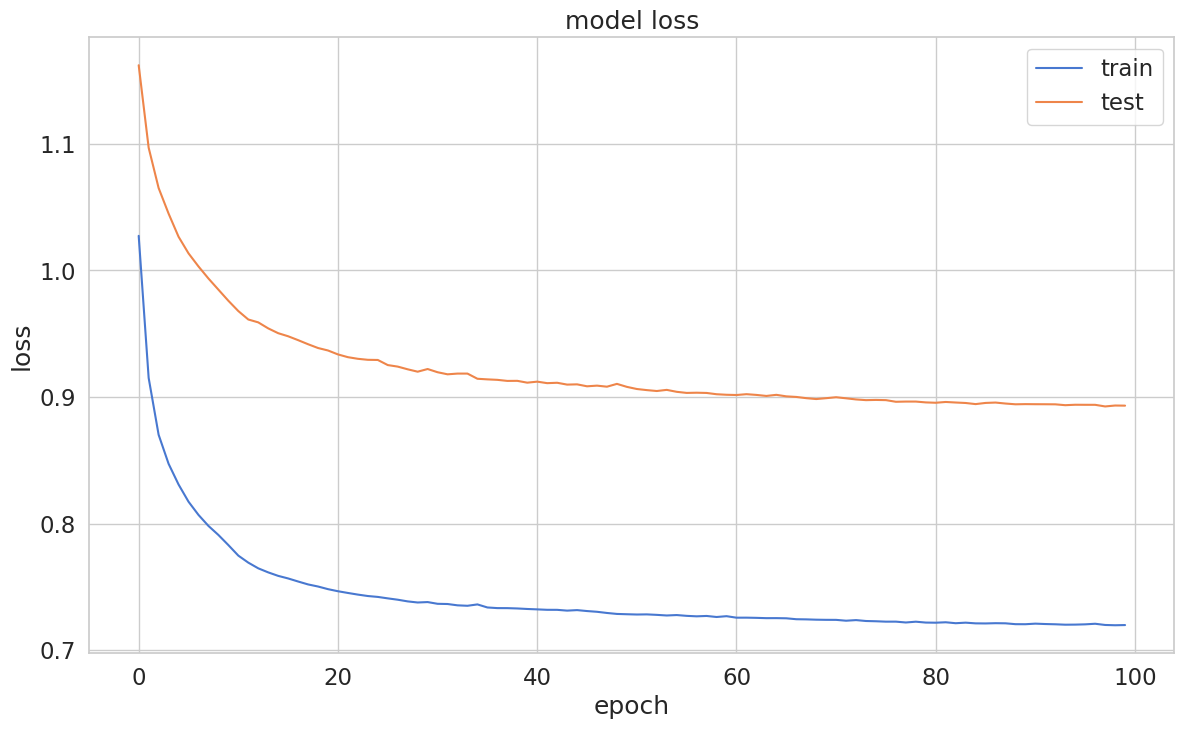

In [32]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [34]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error' : mse, 'true_class': y_test})
error_df.describe()

125/125 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,3980.000000,3980.000000
mean,0.891820,0.003518
std,4.290908,0.059212
min,0.037768,0.000000
25%,0.245060,0.000000
50%,0.402424,0.000000
75%,0.626406,0.000000
max,112.051417,1.000000


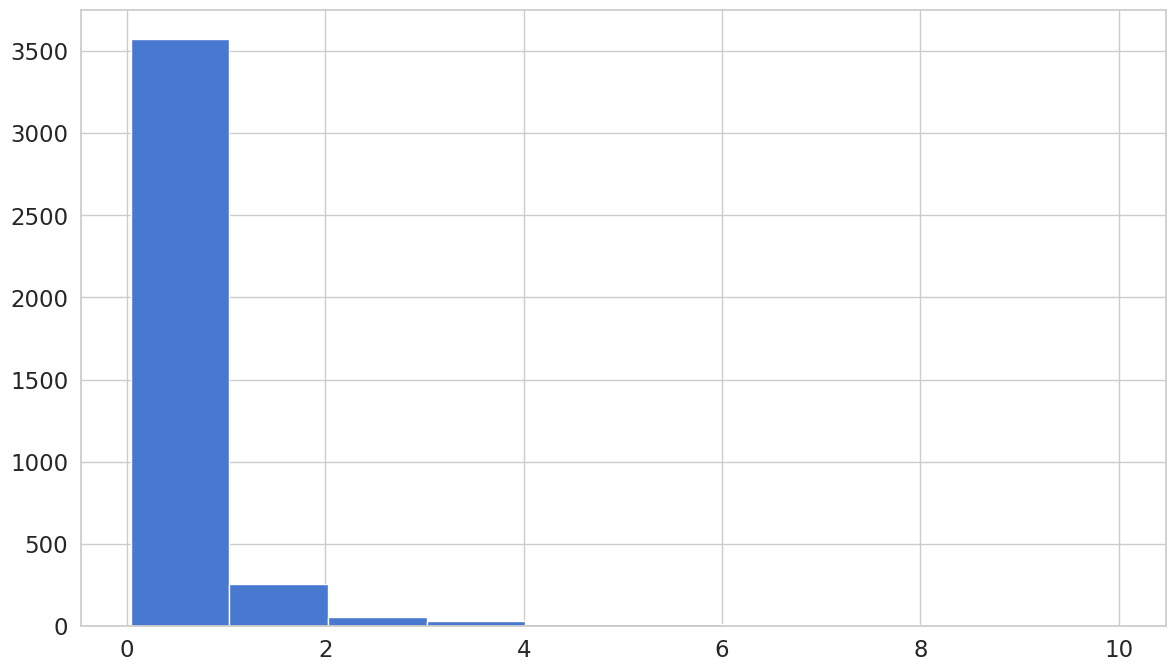

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

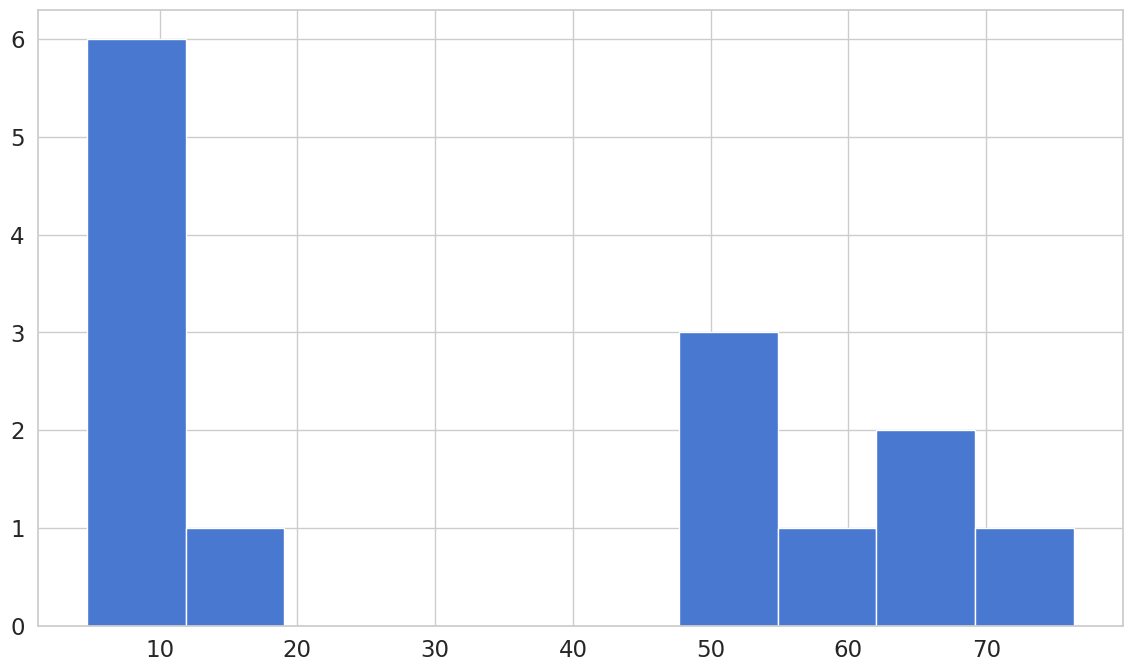

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [37]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

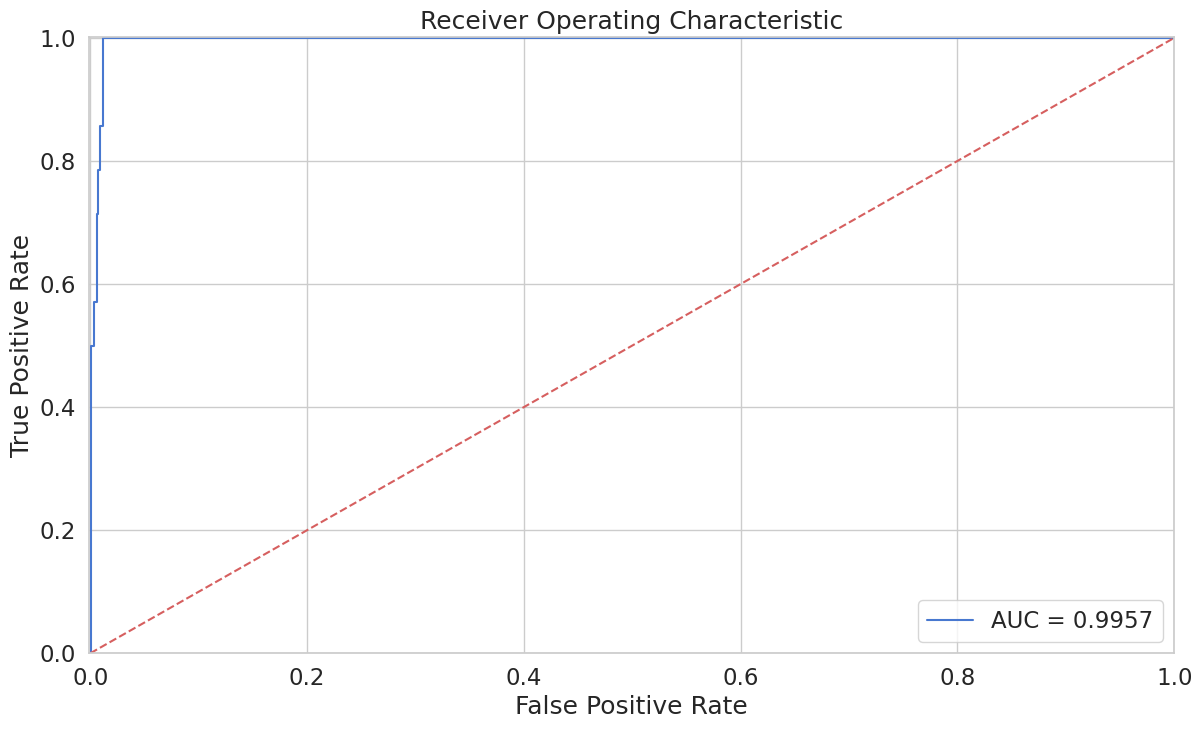

In [39]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

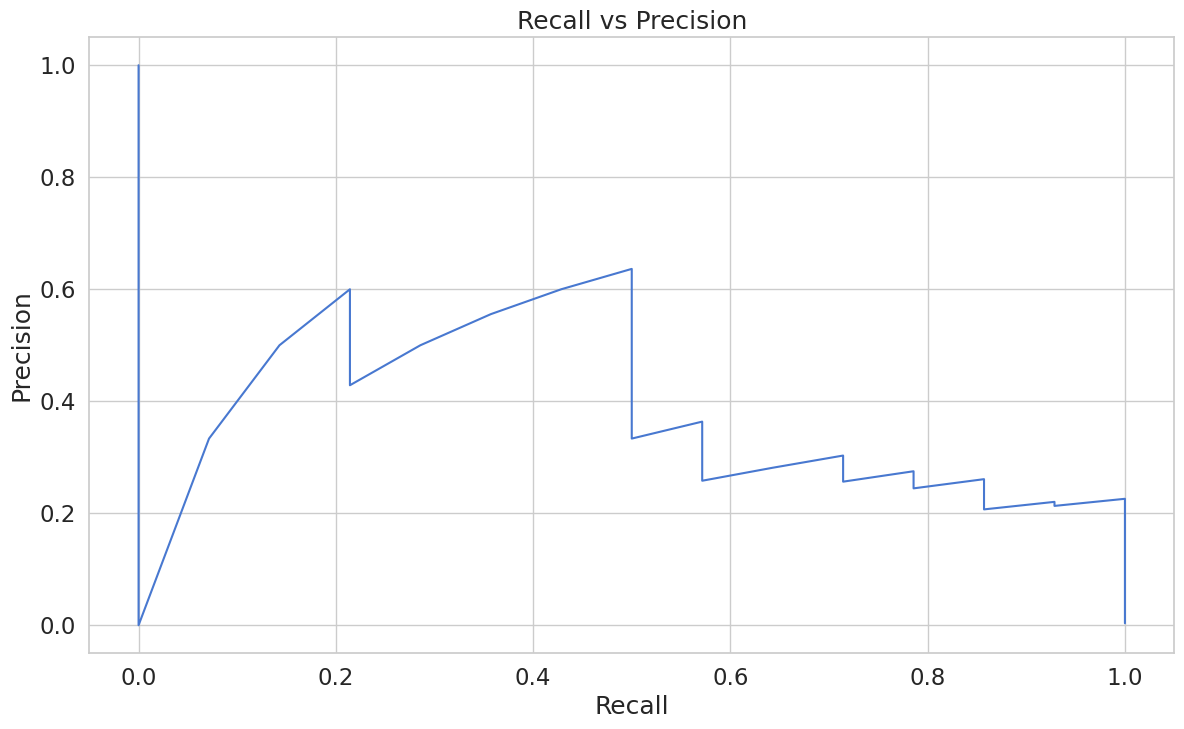

In [41]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

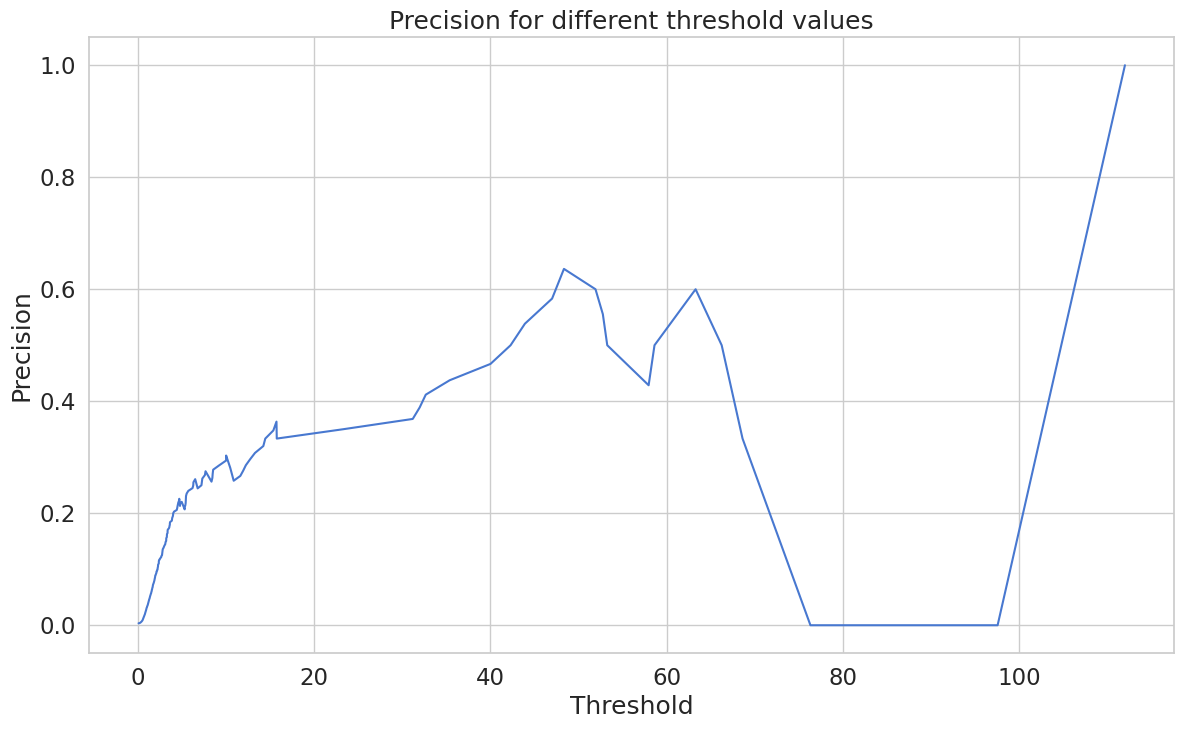

In [44]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

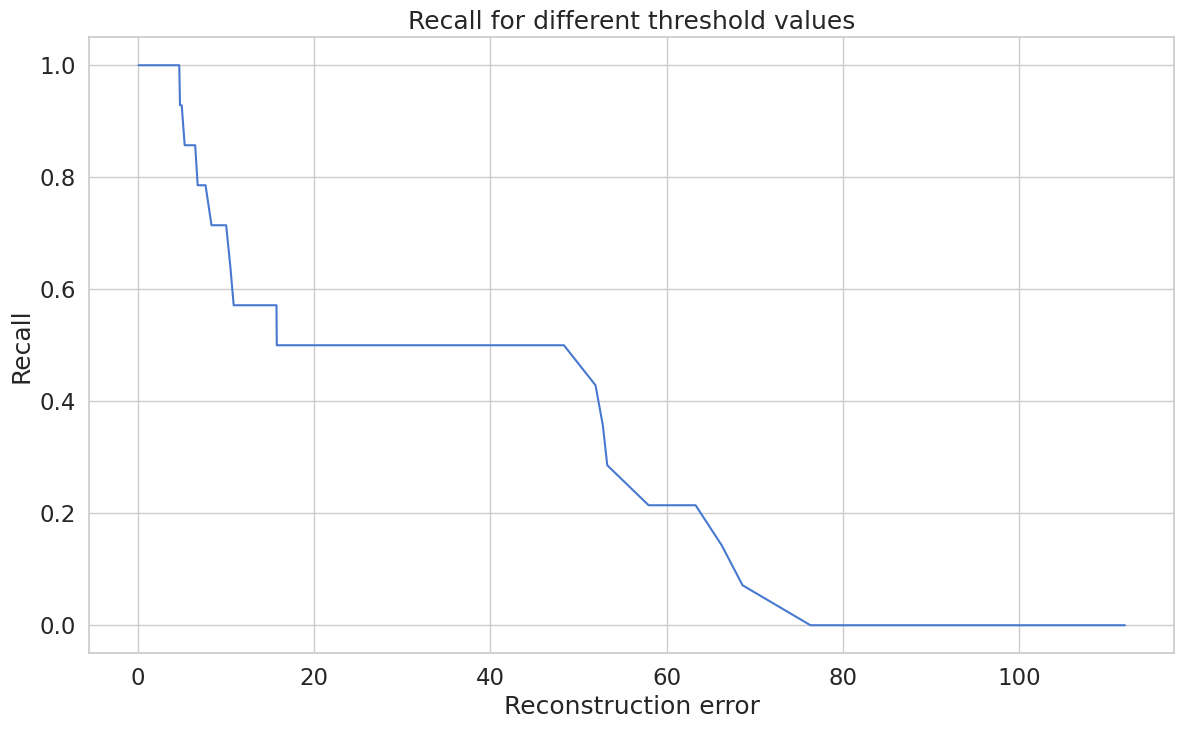

In [43]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [45]:
threshold = 2.9

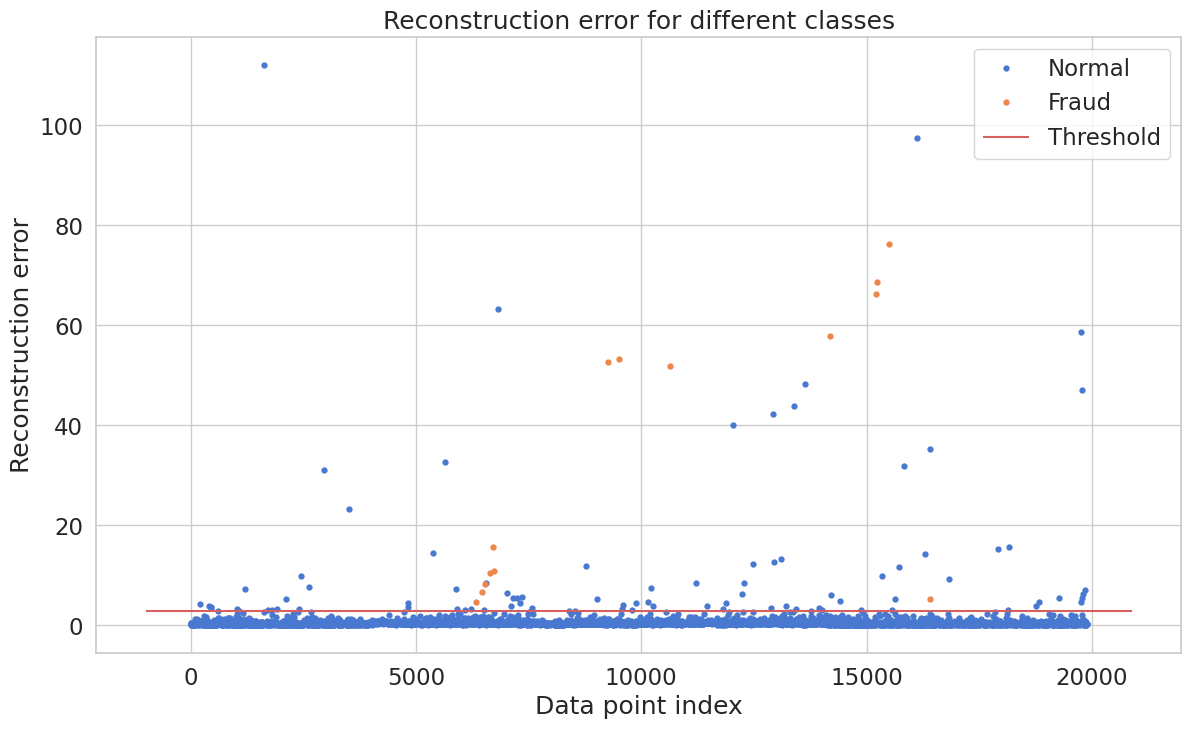

In [49]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
  ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
          label= 'Fraud' if name == 1 else 'Normal')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Threshold')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

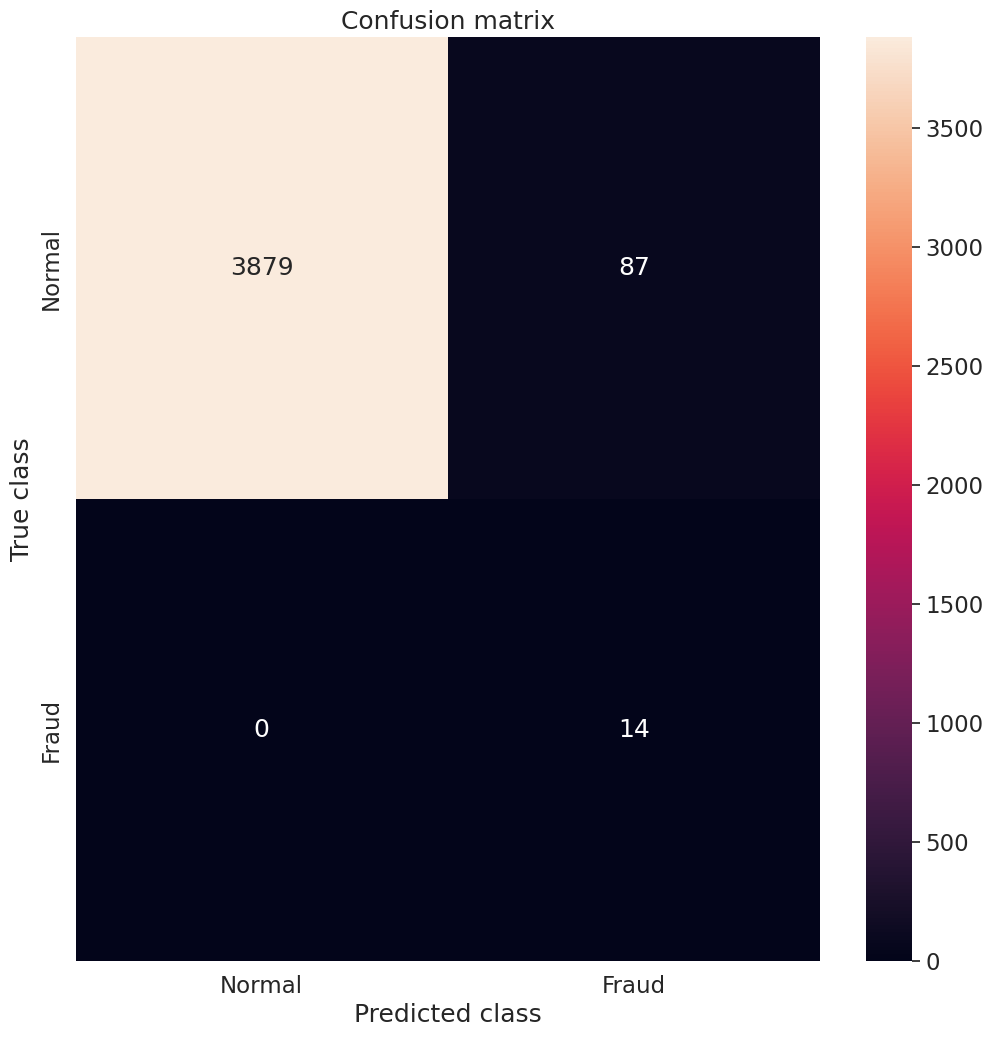

In [50]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize = (12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()